Calculation of rewards for the main branch. Currently all our mechs have the same main branch

In [1]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

#### Setup trajectories 

If the trajectory has an unreachable point the cell with reward calculation will fail!

In [2]:
workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.29], 0.1, 0.24, 20, 40))

ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.05, -0.28], step_height=0.05, step_width=0.1, n_points=50))

left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.1, -0.28], step_height=0.05, step_width=0.1, n_points=50))

right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.0, -0.28], step_height=0.05, step_width=0.1, n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, -0.075, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, 0.075, 50))

#### Characteristics to be calculated

In [3]:
# criteria that either calculated without any reference to points, or calculated through
# the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ), # determinant of the jacobian
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(), # mass term in the dynamic equation with only actuated joints as generalized coordinates
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}

crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

#### set the rewards and weights

In [4]:
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_vertical, 1)
reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(heavy_lifting, 1, 1)


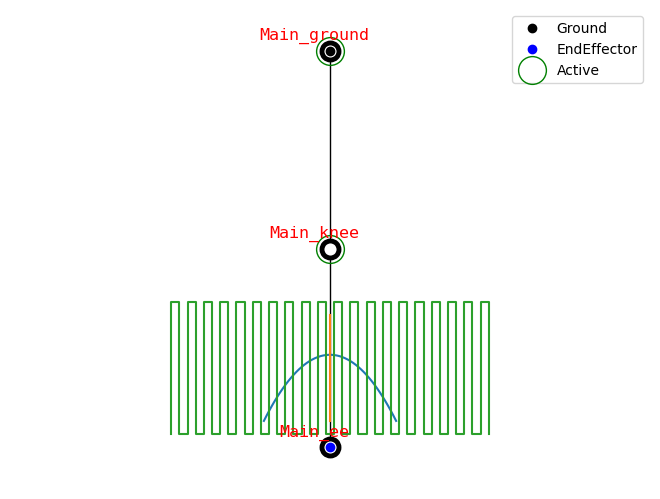

In [5]:

actuator_list = [TMotor_AK10_9(), TMotor_AK60_6(), TMotor_AK70_10(), TMotor_AK80_64(), TMotor_AK80_9()]
generator = TwoLinkGenerator()
generator.build_standard_two_linker()
graph = generator.graph

# open chain is fully actuated
for jp in graph.nodes:
    if not jp.attach_endeffector:
        jp.active = True


draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

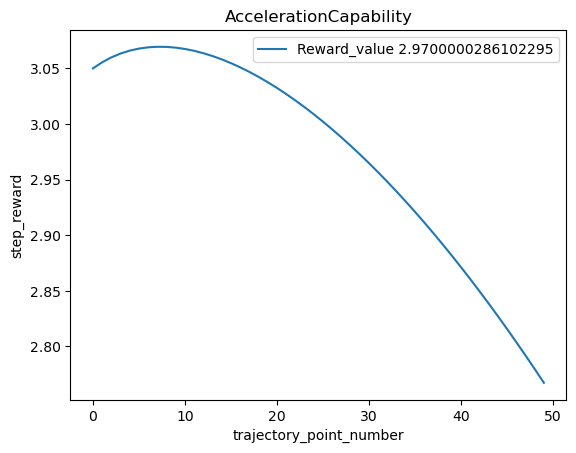

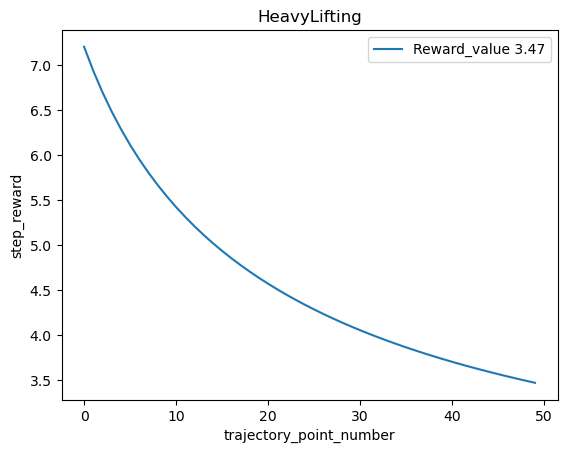

In [6]:
thickness = 0.04    
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
        [thickness*5, thickness*10, thickness*2]), actuator=actuator_list[0], thickness=thickness)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

trajectory = reward_manager.trajectories[1]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator_list[0])
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

trajectory = reward_manager.trajectories[1]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator_list[0])
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()